## Data-Analyse Condensatieplaat

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.ndimage import gaussian_filter1d
import pandas as pd

In [93]:
def Pvapor(T):
    return 611*np.exp(17.625*(T-273.15)/(T - 30.11)) #temperature in kelvin, pressure in pascal

## Data van green village

In [94]:
import pandas as pd

# 1. Load the data 
# (skiprows=300000 if you only want the later part of the data)
path = 'c:/Documenten/Uni/Jaar 4/BEP/DagVerslagen/Weather_Mylan(2)_1dec-12jan-2025 Temp+Hum.csv'
df = pd.read_csv(path, encoding='utf-16')

# 2. Assign temporary column names if the file has no header after skipping
# Let's assume: Col 1 is 'Tag', Col 2 is 'Nanoseconds', Col 4 is 'Value'
df.columns = ['Header', 'Tag', 'Timestamp_NS', 'Extra', 'Measurement']

# 3. Create two separate DataFrames by filtering the 'Tag' column
# 'na=False' ensures random NaNs in the Tag column don't crash the script
df_hum = df[df['Tag'].str.contains('Humidity', na=False)].copy()
df_temp = df[df['Tag'].str.contains('Temperature', na=False)].copy()

df_temp['Measurement'] = pd.to_numeric(df_temp.iloc[:, 3], errors='coerce')

# 4. Convert Nanoseconds to Datetime (Vectorized - very fast)
# 'errors=coerce' turns any bad data into NaT, which we then drop
df_hum['Time'] = pd.to_datetime(df_hum['Timestamp_NS'], unit='ns', errors='coerce')
df_temp['Time'] = pd.to_datetime(df_temp['Timestamp_NS'], unit='ns', errors='coerce')

df_hum = df_hum.dropna(subset=['Time'])
df_temp = df_temp.dropna(subset=['Time'])

# 5. OPTIONAL: If you need to convert back to your dictionary-style strings
# It is better to do this only at the end
df_hum['TimeStr'] = df_hum['Time'].dt.strftime("%Y/%m/%d %H:%M:%S")
df_temp['TimeStr'] = df_temp['Time'].dt.strftime("%Y/%m/%d %H:%M:%S")

# Create your dictionaries
HumDict = dict(zip(df_hum['TimeStr'], df_hum['Measurement']))
TempDict = dict(zip(df_temp['TimeStr'], df_temp['Measurement']))

In [95]:
i = 0
for key in HumDict:
    print(key)
    i += 1
    if i > 10:
        break

2025/12/01 00:00:00
2025/12/01 00:00:05
2025/12/01 00:00:10
2025/12/01 00:00:15
2025/12/01 00:00:20
2025/12/01 00:00:25
2025/12/01 00:00:30
2025/12/01 00:00:35
2025/12/01 00:00:40
2025/12/01 00:00:45
2025/12/01 00:00:50


In [96]:
# #officelab-climate,measurement_id=Outside/ Relative/ Humidity,1764547200000000000,,86
# HumDict = {}
# TempDict = {}

# with open('c:/Documenten/Uni/Jaar 4/BEP/DagVerslagen/Weather_Mylan(2)_1dec-12jan-2025 Temp+Hum.csv', 'r', encoding = 'utf-16') as file:
#     file.readline()
#     reader = csv.reader(file)
#     i = 0
#     for row in reader:
#         tag = row[1].split(' ')[-1]
#         if tag == 'Humidity':
#             for i in range(0,5):
#                 time = dt.datetime.fromtimestamp((int(row[2])/10**9)+i).strftime("%Y/%m/%d %H:%M:%S")
#                 HumDict[time] = row[-1]
#         elif tag == 'Temperature':
#             for i in range(0,5):
#                 time = dt.datetime.fromtimestamp((int(row[2])/10**9)+i).strftime("%Y/%m/%d %H:%M:%S")
#                 TempDict[time] = row[-1]
#         else:
#             print('did not find humidity or temperature, instead: '+ tag)



## Data van sensoren

In [97]:
DataDict = {}

location = 'c:/Documenten/Uni/Jaar 4/BEP/DagVerslagen/'
with open(location + '15-12-2025/Datalog_15-12-2025.TXT', 'r') as file:
    file.readline()
    for line in file:
            line = line.strip()
            if line[0:4] == '2025':
                timestamp_raw = datetime.datetime.strptime(line,"%Y/%m/%d %H:%M:%S")
                seconds = timestamp_raw.second
                # Subtract the remainder to always hit :00, :05, :10, etc.
                rounding_delta = -(seconds % 5) 
                
                final_time = timestamp_raw + datetime.timedelta(seconds = rounding_delta)
                final_time_str = final_time.strftime("%Y/%m/%d %H:%M:%S")
                DataDict[final_time_str] = [] # start a new list for this timestamp
            else:
                old = DataDict[final_time_str]
                new = np.append(old,line)
                DataDict[final_time_str] = new


In [98]:
for key in DataDict:
    print(DataDict[key])

['Green Thermistor Temperature: 1.79 C'
 'White Thermistor Temperature: 1.67 C' 'Humidity: 92.50 %'
 'Ambient Temperature: 7.20 C' 'Sky temperature: 13.57 C']
['Green Thermistor Temperature: 1.79 C'
 'White Thermistor Temperature: 1.80 C' 'Humidity: 92.50 %'
 'Ambient Temperature: 7.20 C' 'Sky temperature: -11.95 C']
['Green Thermistor Temperature: 1.79 C'
 'White Thermistor Temperature: 1.80 C' 'Humidity: 92.50 %'
 'Ambient Temperature: 7.20 C' 'Sky temperature: -12.13 C']
['Green Thermistor Temperature: 1.79 C'
 'White Thermistor Temperature: 1.80 C' 'Humidity: 92.50 %'
 'Ambient Temperature: 7.20 C' 'Sky temperature: 3.77 C']
['Green Thermistor Temperature: 1.66 C'
 'White Thermistor Temperature: 1.80 C' 'Humidity: 92.50 %'
 'Ambient Temperature: 7.20 C' 'Sky temperature: 0.41 C']
['Green Thermistor Temperature: 1.66 C'
 'White Thermistor Temperature: 1.80 C' 'Humidity: 92.50 %'
 'Ambient Temperature: 7.20 C' 'Sky temperature: 4.27 C']
['Green Thermistor Temperature: 1.66 C'
 'White

In [99]:
AmbTemp_false = np.zeros(len(DataDict))
AmbHum_false = np.zeros(len(DataDict))
AmbTemp = np.zeros(len(DataDict))
AmbHum = np.zeros(len(DataDict))
WhiteTemp = np.zeros(len(DataDict))
GreenTemp = np.zeros(len(DataDict))
SkyTemp = np.zeros(len(DataDict))
Time = []
i = 0
for key in DataDict:
    GreenData = DataDict[key][0].split(" ")
    WhiteData = DataDict[key][1].split(" ")
    AmbData = DataDict[key][3].split(" ")
    SkyData = DataDict[key][4].split(" ")
    HumData = DataDict[key][2].split(" ")
    GreenTempValue = GreenData[-2]
    WhiteTempValue = WhiteData[-2]
    AmbTempValue = AmbData[-2]
    HumValue = HumData[-2]
    SkyValue = SkyData[-2]
    GreenTemp[i] = GreenTempValue
    WhiteTemp[i] = WhiteTempValue
    AmbTemp_false[i] = AmbTempValue
    AmbHum_false[i] = HumValue
    AmbTemp[i] = TempDict[key]
    AmbHum[i] = HumDict[key]
    SkyTemp[i] = SkyValue
    T = datetime.datetime.strptime(key, "%Y/%m/%d %H:%M:%S")
    Time.append(T)
    i +=1

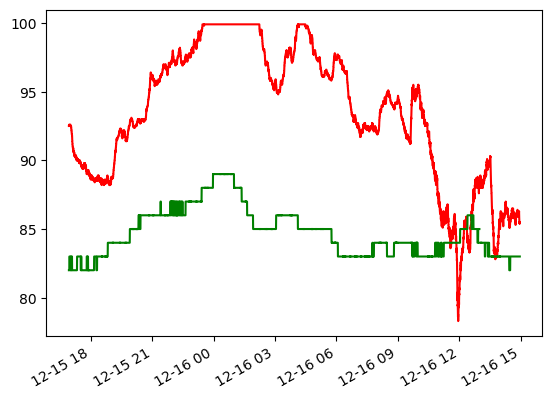

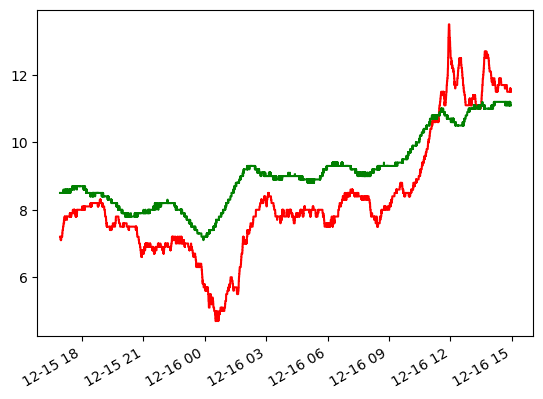

In [104]:
plt.figure(1)
plt.plot(Time, AmbHum_false, 'r-')
plt.plot(Time, AmbHum, 'g-')
plt.gcf().autofmt_xdate()
plt.show()

plt.figure(2)
plt.plot(Time, AmbTemp_false, 'r-')
plt.plot(Time, AmbTemp, 'g-')
plt.gcf().autofmt_xdate()
plt.show()


In [111]:
SkyTemp_blurred = gaussian_filter1d(SkyTemp, 15)

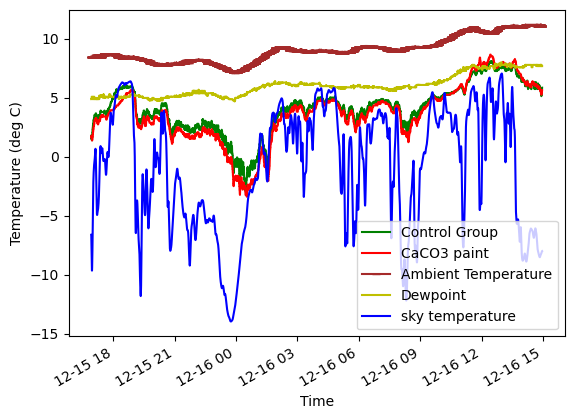

In [112]:
dewpoint = AmbTemp - (100-AmbHum)/5

plt.figure()
plt.plot(Time, GreenTemp, 'g-',  label = 'Control Group')
plt.plot(Time, WhiteTemp, 'r-', label = 'CaCO3 paint')
plt.plot(Time, AmbTemp, color = 'brown', marker = '_', label = 'Ambient Temperature')
plt.plot(Time, dewpoint, 'y-', label = 'Dewpoint')
plt.plot(Time, SkyTemp_blurred, 'b-', label = 'sky temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (deg C)')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()